*Step 1. Problem Understanding*

1.1 Dataset selection:

**Name**: Netflix Movies and TV Shows

**Source**: https://www.kaggle.com/datasets/shivamb/netflix-shows

**Description**:

The "Netflix Shows" dataset, available on Kaggle, contains detailed information about movies and TV shows available on Netflix as of 2019. This dataset includes over 6,000 records, each representing a unique show or movie, and features various attributes such as the show's title, director, cast, country of production, date added to Netflix, release year, rating, duration, and listed genres. The dataset is useful for exploring content trends on Netflix, performing content-based analysis like genre popularity, and predicting attributes such as the maturity rating of a show based on its metadata.

Number of Instances: 8807
Number of Attributes: 12
Attribute Information:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object

1.2 Defining a prediction task

**Prediction Task**:

The Content Rating Prediction task aims to predict the maturity ratings of Netflix shows based on features like descriptions, cast, directors, and genre. It involves classifying these shows into categories such as TV-MA, TV-14, etc., using machine learning techniques.

In [ ]:
#Step 2: DATA PREPARATION

# 2.1.1 Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_validate, learning_curve
from scipy.sparse import hstack


%matplotlib inline

sns.set()


In [ ]:
# 2.1.2 Load the dataset

data = pd.read_csv('netflix_titles.csv')

In [ ]:
# 2.1.3 Display the first few rows of the dataset to understand its structure

print(data.head())

  show_id     type                  title         director  \
0      s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1      s2  TV Show          Blood & Water              NaN   
2      s3  TV Show              Ganglands  Julien Leclercq   
3      s4  TV Show  Jailbirds New Orleans              NaN   
4      s5  TV Show           Kota Factory              NaN   

                                                cast        country  \
0                                                NaN  United States   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...   South Africa   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...            NaN   
3                                                NaN            NaN   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...          India   

           date_added  release_year rating   duration  \
0  September 25, 2021          2020  PG-13     90 min   
1  September 24, 2021          2021  TV-MA  2 Seasons   
2  September 24, 2021        

In [ ]:
# 2.1.4 Display summary information about the dataset, including data types and non-null counts

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None


In [ ]:
# 2.1.5 Check for missing values in the dataset
print(data.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


In [ ]:
# 2.2.1 Handle missing values

# Convert 'duration' to integers by stripping 'min' and other non-numeric characters
data['duration'] = data['duration'].str.extract('(\d+)').astype(float)

# Fill missing 'duration' with the median of the column now that it's numeric
duration_median = data['duration'].median()
data['duration'].fillna(duration_median, inplace=True)

# Fill 'director' and 'cast' with 'Unknown'
data['director'].fillna('Unknown', inplace=True)
data['cast'].fillna('Unknown', inplace=True)

# Fill 'country' with 'Unknown' or the mode
country_mode = data['country'].mode()[0]
data['country'].fillna(country_mode, inplace=True)

# Drop rows where 'date_added' is missing
data.dropna(subset=['date_added'], inplace=True)

# Drop rows where 'rating' is missing
data.dropna(subset=['rating'], inplace=True)

# 2.2.2 Confirm no more missing values
print(data.isnull().sum())


show_id         0
type            0
title           0
director        0
cast            0
country         0
date_added      0
release_year    0
rating          0
duration        0
listed_in       0
description     0
dtype: int64


In [ ]:
# Step 2. Data Preparation
# 2.2 Creating features or encoding categorical values

# 2.2.1 Label encode the 'rating' target variable for classification
label_encoder = LabelEncoder()
data['rating'] = label_encoder.fit_transform(data['rating'])

# Save the encoder for inverse transformation during interpretation or deployment
import joblib
joblib.dump(label_encoder, 'rating_label_encoder.joblib')

# 2.2.2 One-hot encode other categorical variables that require nominal encoding
categorical_features = ['type', 'country']  # Example of categorical features to encode
data = pd.get_dummies(data, columns=categorical_features, drop_first=True)

# 2.3 Applying feature scaling or normalization

# 2.3.1 Scale numerical features that benefit from normalization
numerical_features = ['release_year', 'duration']  # Example of numerical features
scaler = StandardScaler()
data[numerical_features] = scaler.fit_transform(data[numerical_features])

# Save the scaler for later use
joblib.dump(scaler, 'features_scaler.joblib')

# 2.4 Check the transformed dataset to verify changes
print(data.head())


  show_id                  title         director  \
0      s1   Dick Johnson Is Dead  Kirsten Johnson   
1      s2          Blood & Water          Unknown   
2      s3              Ganglands  Julien Leclercq   
3      s4  Jailbirds New Orleans          Unknown   
4      s5           Kota Factory          Unknown   

                                                cast          date_added  \
0                                            Unknown  September 25, 2021   
1  Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...  September 24, 2021   
2  Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...  September 24, 2021   
3                                            Unknown  September 24, 2021   
4  Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...  September 24, 2021   

   release_year  rating  duration  \
0      0.659241       7  0.394994   
1      0.772573      11 -1.337836   
2      0.772573      11 -1.357527   
3      0.772573      11 -1.357527   
4      0.772573      11 -1.337836   

 

In [ ]:
# 3.1 Analyzing Basic Trend Statistics
print("Summary Statistics:\n", data.describe())



Summary Statistics:
        release_year       rating      duration
count  8.793000e+03  8793.000000  8.793000e+03
mean   3.555542e-15    10.014216 -1.616155e-17
std    1.000057e+00     1.957209  1.000057e+00
min   -1.010731e+01     0.000000 -1.357527e+00
25%   -1.340832e-01     9.000000 -1.337836e+00
50%    3.192451e-01    11.000000  3.556115e-01
75%    5.459093e-01    11.000000  7.100540e-01
max    7.725735e-01    16.000000  4.766452e+00


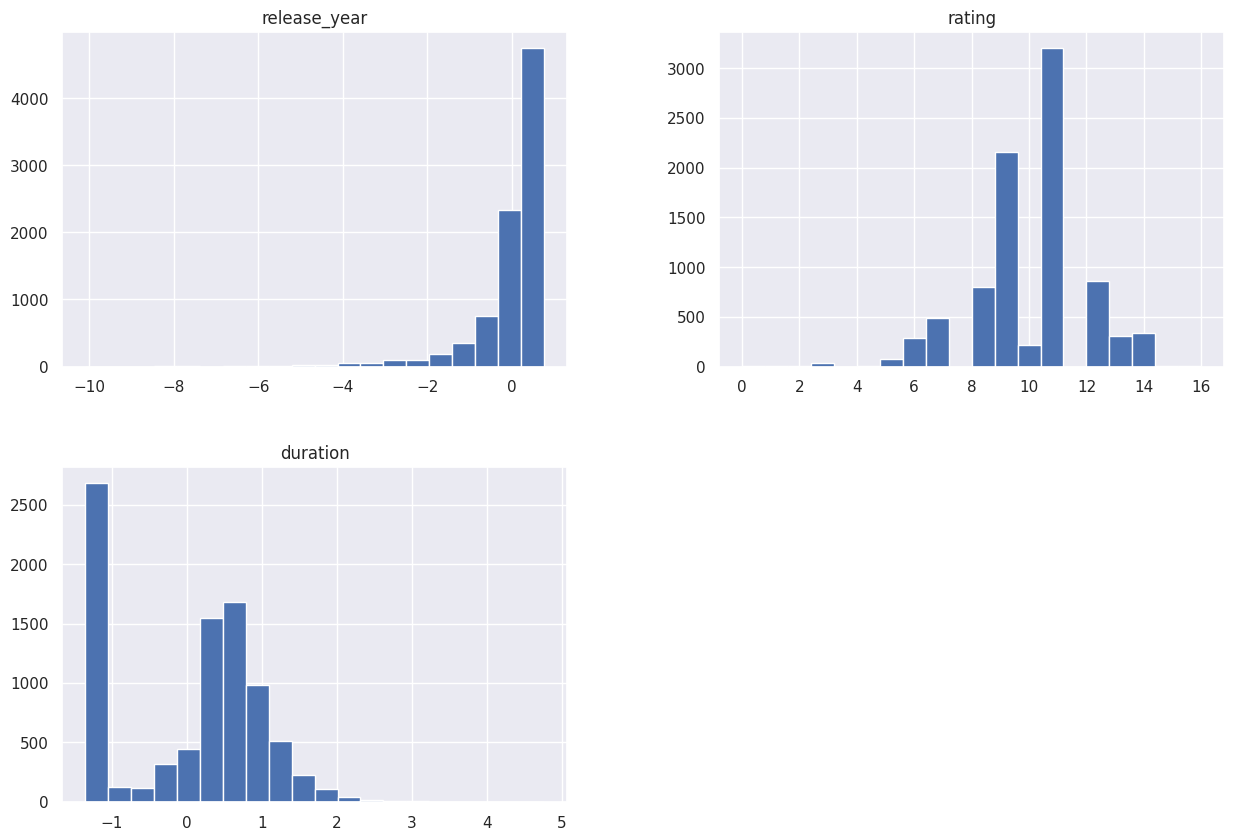

In [ ]:
# 3.2 Generating Visualizations

# 3.2.1 Histograms for distribution analysis
data.hist(bins=20, figsize=(15, 10))
plt.show()

**Analysis**:

Release Year:

The data is left-skewed, meaning that there are more recent releases in the dataset.

Rating:

This histogram shows multiple peaks, which suggests that there are several common ratings that the shows fall into. The labels on the x-axis are numeric because I applied label encoding to the ratings, which converted the rating categories to numeric values.

Duration:

The distribution seems to be right-skewed, meaning that there are shows of varying lengths, with most of the shows being shorter.


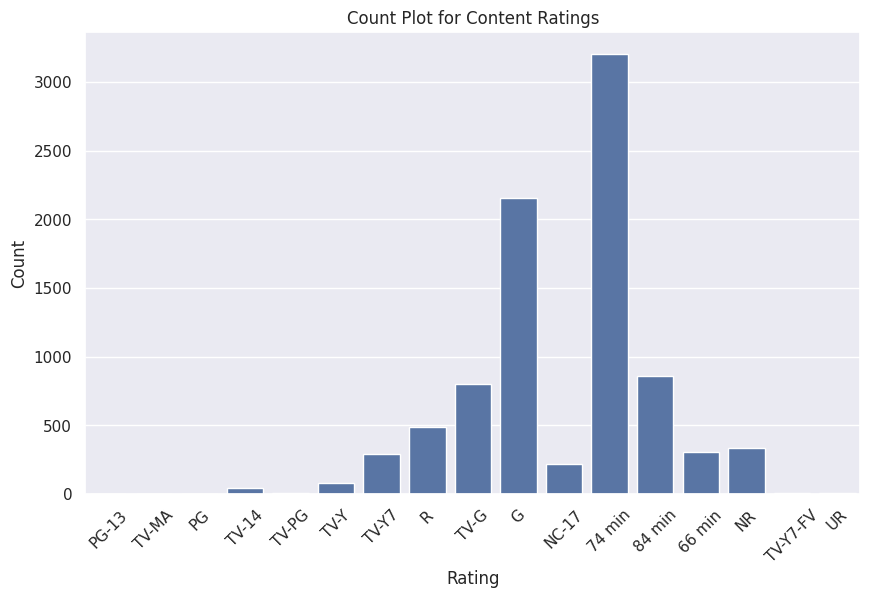

In [ ]:
# 3.2.2 Count plot for 'rating' variable
plt.figure(figsize=(10, 6))
sns.countplot(x=data['rating'])
plt.title('Count Plot for Content Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
# Map the encoded labels back to their original string format if needed
rating_labels = label_encoder.inverse_transform(data['rating'].unique())
plt.xticks(ticks=range(len(rating_labels)), labels=rating_labels, rotation=45)
plt.show()

Analysis:

The graph shows that some ratings are more frequent than others. 74 min and G have the highest count.

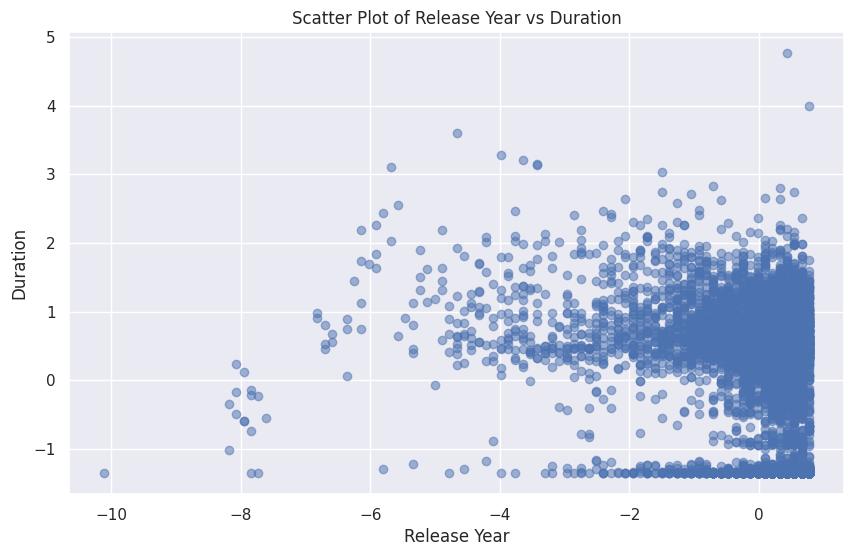

In [ ]:
# 3.2.3 Scatter plots to check relationships between key features
if 'release_year' in data.columns and 'duration' in data.columns:
    plt.figure(figsize=(10, 6))
    plt.scatter(data['release_year'], data['duration'], alpha=0.5)
    plt.title('Scatter Plot of Release Year vs Duration')
    plt.xlabel('Release Year')
    plt.ylabel('Duration')
    plt.show()

Analysis:

The x-axis (Release Year) shows that the data points are more concentrated towards the right, indicating that there are more releases closer to the current year, as expected from the earlier histogram.

The y-axis (Duration) displays a wide spread of values. There’s a dense concentration of points around the center, suggesting many titles have a duration close to the average.

There’s no distinct upward or downward trend, which might indicate that there's no strong linear relationship between release year and duration.

There are a few points spread across higher values of the y-axis, which could be representing outliers or just content with significantly longer duration.

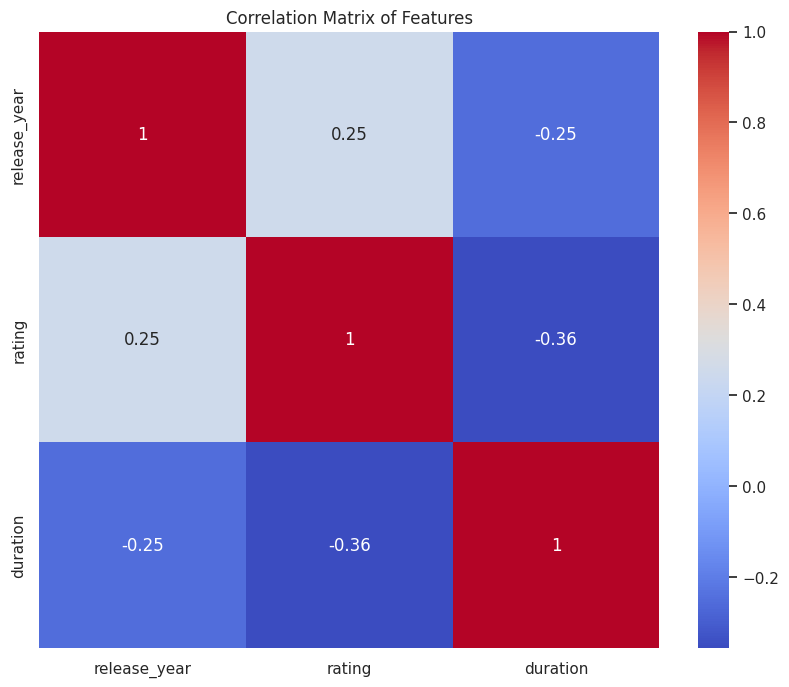

In [ ]:
# 3.3 Conducting Correlation Analysis
# Select only numeric data for correlation analysis
numeric_data = data.select_dtypes(include=[np.number])
correlation_matrix = numeric_data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Features')
plt.show()

Analysis:

The red diagonal is all 1s, as expected, since that represents the correlation of each feature with itself.
The other squares show the correlation coefficients between the different features, which range between -1 and 1. There is a slight positive correlation between release_year and rating (0.25).
There is a slight negative correlation between release_year and duration (-0.25).
There is a moderate negative correlation between rating and duration (-0.36).
The values suggest that there may be some relationships between these features, but they are not very strong.

In [ ]:
# 4.1 Feature Engineering

# 4.1.1 One-hot encode 'Listed In (Genres)'
genres_ohe = OneHotEncoder()
genres_encoded = genres_ohe.fit_transform(data[['listed_in']])

In [ ]:
# 4.1.2 One-hot encode 'Director' - taking top 20 directors as an example
top_directors = data['director'].value_counts().index[:20]
data['director'] = data['director'].where(data['director'].isin(top_directors), 'Other')
director_ohe = OneHotEncoder()
director_encoded = director_ohe.fit_transform(data[['director']])

In [ ]:
# 4.1.3 Standardize 'Duration'
scaler_duration = StandardScaler()
duration_scaled = scaler_duration.fit_transform(data[['duration']])

In [ ]:
# 4.1.4 Standardize 'Release Year'
scaler_release_year = StandardScaler()
release_year_scaled = scaler_release_year.fit_transform(data[['release_year']])

In [ ]:
# 4.1.5 Ensure Duration and Release Year are scaled correctly
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[['duration', 'release_year']])


In [ ]:
# Extract pre-existing one-hot encoded country columns
country_columns = [col for col in data.columns if col.startswith('country_')]
country_encoded = data[country_columns].values


In [ ]:
# Combine all features into one feature set
features = hstack([genres_encoded, director_encoded, country_encoded, scaled_features])

# Prepare target variable
target = data['rating']

In [ ]:
# 4.2 Split the data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
# 5.1 Model Selection

# Initialize the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
# 5.2 Model Training

# Train the Logistic Regression model
logreg_model.fit(X_train, Y_train) # This code starts a Logistic Regression model with max_iter set to 1000 to ensure convergence
# and then fits it to the training data

# Train the Random Forest model
rf_model.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# 5.3 Model Evaluation

# This step involves predicting the content ratings using the test features
# and comparing the predictions to the actual ratings.

# Predict the content ratings on the test set using Logistic Regression
Y_pred_logreg = logreg_model.predict(X_test)

# Predict the content ratings on the test set using Random Forest
Y_pred_rf = rf_model.predict(X_test)

# Generate and print classification reports
classification_report_logreg = classification_report(Y_test, Y_pred_logreg)
classification_report_rf = classification_report(Y_test, Y_pred_rf)

print("Logistic Regression Classification Report:\n", classification_report_logreg)
print("Random Forest Classification Report:\n", classification_report_rf)

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           3       0.00      0.00      0.00        10
           5       0.00      0.00      0.00        18
           6       0.56      0.52      0.54        52
           7       0.49      0.37      0.43        99
           8       0.52      0.48      0.50       168
           9       0.50      0.52      0.51       420
          10       0.20      0.03      0.05        39
          11       0.59      0.77      0.67       651
          12       0.42      0.13      0.20       186
          13       0.66      0.72      0.69        61
          14       0.51      0.53      0.52        55

    accuracy                           0.55      1759
   macro avg       0.40      0.37      0.37      1759
weighted avg       0.52      0.55      0.52      1759

Random Forest Classification Report:
               precision    recall  f1-score   support

           2       0.00      0.00      0.00       

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

In [ ]:
# Step 6. Evaluation Phase

# 6.1 k-Fold Cross-Validation

# Define the number of folds
k = 5

# 6.1.1 Cross-validation for Logistic Regression
cv_scores_logreg = cross_val_score(logreg_model, X_train, Y_train, cv=k, scoring='accuracy')
print("Logistic Regression CV Accuracy Scores:", cv_scores_logreg)

# 6.1.2 Cross-validation for Random Forest
cv_scores_rf = cross_val_score(rf_model, X_train, Y_train, cv=k, scoring='accuracy')
print("Random Forest CV Accuracy Scores:", cv_scores_rf)


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Logistic Regression CV Accuracy Scores: [0.52807392 0.52025586 0.54442075 0.5387349  0.52916074]


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Random Forest CV Accuracy Scores: [0.52452026 0.51172708 0.52452026 0.51954513 0.51422475]


In [ ]:
# 6.2.1 Scoring Metrics (precision, recall, and the F1 score) Evaluation

# Define the scoring metrics
scoring_metrics = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']

# 6.2.2 Cross-validation for Logistic Regression
cv_results_logreg = cross_validate(logreg_model, X_train, Y_train, cv=5, scoring=scoring_metrics)
print("Logistic Regression CV Metrics:")
for metric in scoring_metrics:
    print(f"{metric}: {cv_results_logreg['test_' + metric]}")

# 6.2.3 Cross-validation for Random Forest
cv_results_rf = cross_validate(rf_model, X_train, Y_train, cv=5, scoring=scoring_metrics)
print("Random Forest CV Metrics:")
for metric in scoring_metrics:
    print(f"{metric}: {cv_results_rf['test_' + metric]}")


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` par

Logistic Regression CV Metrics:
accuracy: [0.52807392 0.52025586 0.54442075 0.5387349  0.52916074]
precision_weighted: [0.49682847 0.50949106 0.52695395 0.50245731 0.49500447]
recall_weighted: [0.52807392 0.52025586 0.54442075 0.5387349  0.52916074]
f1_weighted: [0.50067689 0.49421716 0.51406351 0.50892502 0.50336301]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precis

Random Forest CV Metrics:
accuracy: [0.52452026 0.51172708 0.52452026 0.51954513 0.51422475]
precision_weighted: [0.51397688 0.49252178 0.50507114 0.50098547 0.48965975]
recall_weighted: [0.52452026 0.51172708 0.52452026 0.51954513 0.51422475]
f1_weighted: [0.51084291 0.49745003 0.50910354 0.50455974 0.4963876 ]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# 6.3 Evaluate models for overfitting

# Training vs. Validation Performance Comparison

# 6.3.1 Train performance
train_accuracy_logreg = logreg_model.score(X_train, Y_train)
train_accuracy_rf = rf_model.score(X_train, Y_train)

In [ ]:
# 6.3.2 Test performance
test_accuracy_logreg = logreg_model.score(X_test, Y_test)
test_accuracy_rf = rf_model.score(X_test, Y_test)

print(f"Logistic Regression - Train Accuracy: {train_accuracy_logreg}, Test Accuracy: {test_accuracy_logreg}")
print(f"Random Forest - Train Accuracy: {train_accuracy_rf}, Test Accuracy: {test_accuracy_rf}")


Logistic Regression - Train Accuracy: 0.6151549616150128, Test Accuracy: 0.5474701534963047
Random Forest - Train Accuracy: 0.9583451805516064, Test Accuracy: 0.5173393973848778


In [ ]:
# 6.3.3 Learning Curves
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 1, figsize=(20, 5))

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring="accuracy")
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                      train_scores_mean + train_scores_std, color="r", alpha=0.1)
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                      test_scores_mean + test_scores_std, color="g", alpha=0.1)
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    axes.legend(loc="best")

    return plt

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


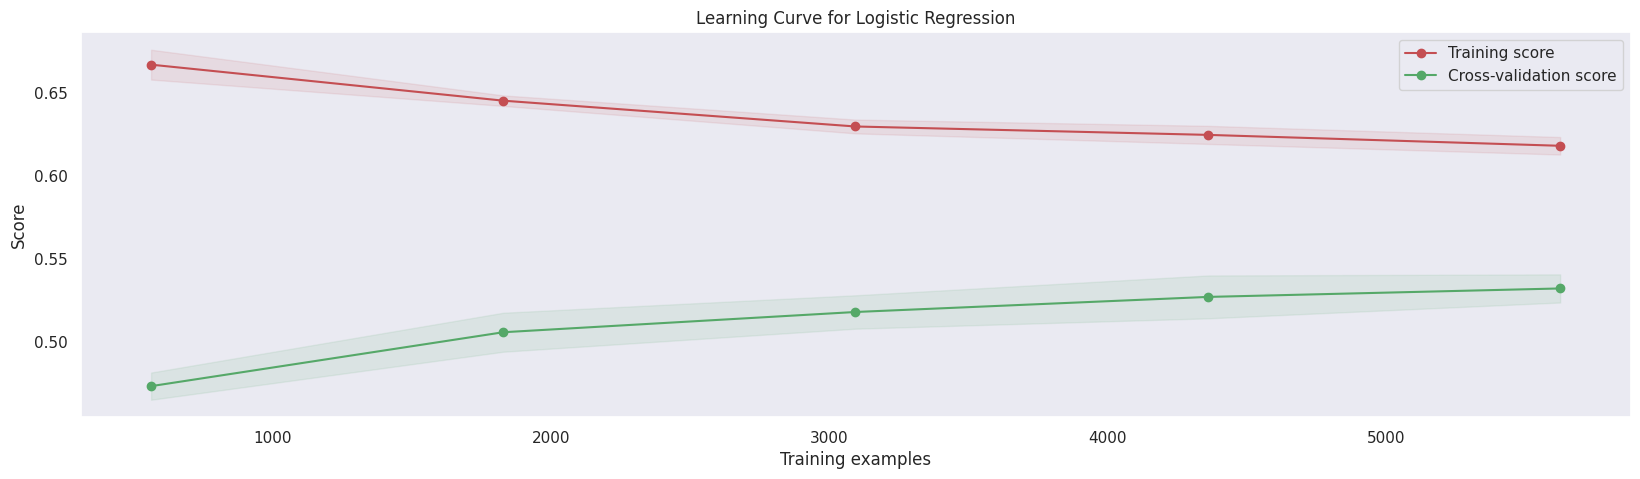

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


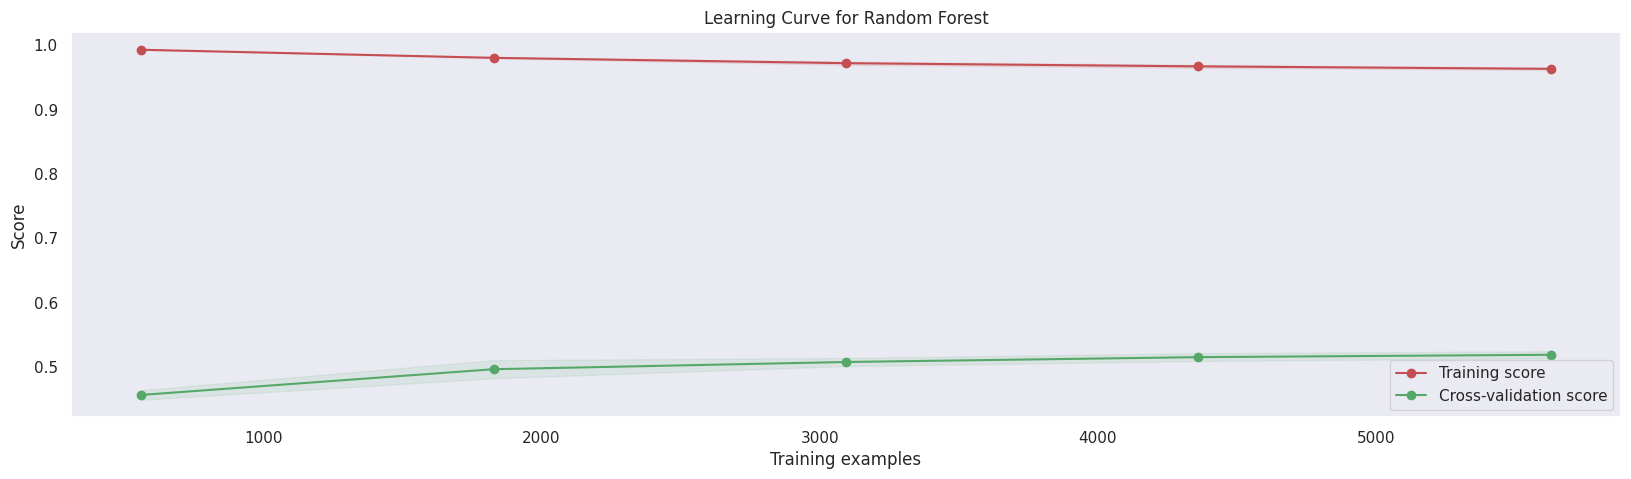

In [ ]:
# Plot learning curve for Logistic Regression
plot_learning_curve(logreg_model, "Learning Curve for Logistic Regression", X_train, Y_train, cv=5)
plt.show()

# Plot learning curve for Random Forest
plot_learning_curve(rf_model, "Learning Curve for Random Forest", X_train, Y_train, cv=5)
plt.show()

In [ ]:
# 6.4 Identify the most important features.

# Code for fitting the OneHotEncoder for the 'country' data

original_country_data = data.filter(regex='^country_.*$')

# I need to reverse the one-hot encoding to get back the original data.
# Create a reverse mapping from one-hot encoded columns back to original country names
country_mapping = {idx: country.replace('country_', '') for idx, country in enumerate(original_country_data.columns)}

# Get the index of the 1 value in each one-hot encoded row
country_indices = original_country_data.idxmax(axis=1)

# Map the indices back to original country names
original_countries = country_indices.map(country_mapping)

# Fit the OneHotEncoder again to get the categories_
countries_ohe = OneHotEncoder()
countries_ohe.fit(original_countries.to_frame())

# Now the categories_ attribute should be set
country_names = countries_ohe.categories_[0]


In [ ]:
# Construct a more detailed mapping back to the original category names
# This code assigns the importances to the actual category names from the one-hot encoders and then sorts and prints them.
genre_names = genres_ohe.categories_[0]
director_names = director_ohe.categories_[0]
country_names = countries_ohe.categories_[0]

# Split the feature importances array into corresponding parts
genres_importance = importances_rf[:len(genre_names)]
directors_importance = importances_rf[len(genre_names):len(genre_names) + len(director_names)]
countries_importance = importances_rf[len(genre_names) + len(director_names):-2]
duration_importance = importances_rf[-2]
release_year_importance = importances_rf[-1]

# Map the importances to the feature names
importances_mapped = {}
importances_mapped.update(dict(zip(genre_names, genres_importance)))
importances_mapped.update(dict(zip(director_names, directors_importance)))
importances_mapped.update(dict(zip(country_names, countries_importance)))
importances_mapped['Duration'] = duration_importance
importances_mapped['Release Year'] = release_year_importance

# Sort the features by importance
sorted_importances = sorted(importances_mapped.items(), key=lambda item: item[1], reverse=True)

# Display the sorted importances
print("Feature Importances:")
for feature, importance in sorted_importances:
    print(f"{feature}: {importance}")


Feature Importances:
Duration: 0.22198417123980205
Release Year: 0.18965354994981856
Kids' TV: 0.0194166483004742
Children & Family Movies, Comedies: 0.01572682637531619
Children & Family Movies: 0.015138133258676923
Stand-Up Comedy: 0.010490160007557493
Other: 0.00814211868606648
Kids' TV, TV Comedies: 0.007650854759245844
Action & Adventure: 0.0073996843952742804
Unknown: 0.006934152949385975
Documentaries: 0.005192303446218158
Comedies, Dramas, International Movies: 0.004626189777421473
Dramas, International Movies: 0.004616733893360884
Action & Adventure, Sci-Fi & Fantasy: 0.004038704292190524
Documentaries, International Movies: 0.0039321546438225415
Dramas: 0.003856136507410162
Dramas, International Movies, Romantic Movies: 0.003814092553745534
Dramas, Independent Movies: 0.00359815170677066
Dramas, Independent Movies, International Movies: 0.003596247563533577
Comedies, International Movies: 0.003546869440975186
Comedies, International Movies, Romantic Movies: 0.0034296351348021

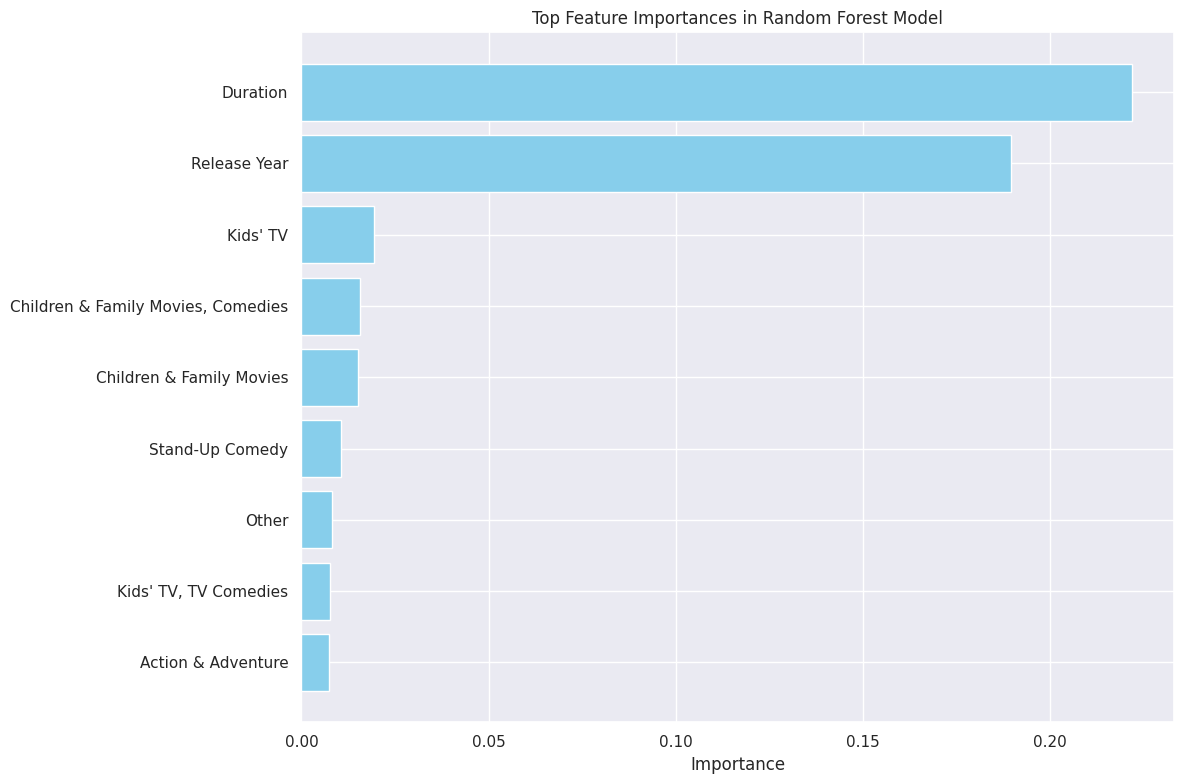

In [ ]:
import matplotlib.pyplot as plt

# Top features and their importances as extracted from your previous messages
feature_names = [
    'Duration', 'Release Year', "Kids' TV", "Children & Family Movies, Comedies",
    "Children & Family Movies", "Stand-Up Comedy", "Other", "Kids' TV, TV Comedies",
    "Action & Adventure"
]
importances = [0.22198417123980205, 0.18965354994981856, 0.0194166483004742, 0.01572682637531619,
               0.015138133258676923, 0.010490160007557493, 0.00814211868606648, 0.007650854759245844,
               0.0073996843952742804]

# Sort features by importance
sorted_indices = np.argsort(importances)[::-1]
sorted_features = np.array(feature_names)[sorted_indices]
sorted_importances = np.array(importances)[sorted_indices]

# Create the plot
plt.figure(figsize=(12, 8))
plt.barh(sorted_features, sorted_importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Top Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important on top
plt.tight_layout()  # Adjust layout to make room for label

# Show the plot
plt.show()


Analysis:

Duration and Release Year: These two features are the most important, indicating that the length of the shows and their release dates have strong predictive power for the content rating. This suggests that content rating could be influenced by trends over time and the length of the content, possibly due to changing standards in rating systems or differences in movie versus series durations.

 6.5 **The results of the model evaluations**:

The Logistic Regression model hovered around a 53% accuracy, with its best showing at 54.4%. This simple model is good for quick insights but struggles with the complexity of our dataset. Random Forest didn't improve much on accuracy, peaking similarly around 52-54%, but it overfit the training data—a classic trade-off with more complex models.

'Duration' and 'Release Year' were top features for both models, suggesting the length and time period of a show are telling for its content rating. The Random Forest picked out specific genres and directors too, hinting at certain storytelling styles being predictable for ratings. Yet, its overfitting points to learning from the noise rather than just the signal.

These models are a decent start but we need to balance complexity with generalizability. We're onto something with 'Duration' and 'Release Year', and with some tweaking, there's potential to improve.


In [ ]:
# Step 7. Deployment Phase
# Make predictions and classifications with new data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv('netflix_titles.csv')  # Adjust path as necessary

# Let's preprocess a few columns for simplicity
# Extracting numeric duration
df['duration'] = df['duration'].str.extract('(\d+)').astype(float)

# For simplicity, let's use only a few columns and drop rows with missing values
df = df[['director', 'duration', 'release_year', 'listed_in']].dropna()

# Splitting genres just for demonstration (taking only the first genre listed)
df['listed_in'] = df['listed_in'].apply(lambda x: x.split(", ")[0])

# Split dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Encoders and scalers
director_ohe = OneHotEncoder(handle_unknown='ignore')
genres_ohe = OneHotEncoder(handle_unknown='ignore')
scaler_duration = StandardScaler()
scaler_release_year = StandardScaler()

# Fitting encoders and scalers on training data
director_ohe.fit(train_df[['director']])
genres_ohe.fit(train_df[['listed_in']])
scaler_duration.fit(train_df[['duration']])
scaler_release_year.fit(train_df[['release_year']])

# Prepare features
def prepare_features(df):
    directors = director_ohe.transform(df[['director']])
    genres = genres_ohe.transform(df[['listed_in']])
    duration = scaler_duration.transform(df[['duration']])
    release_year = scaler_release_year.transform(df[['release_year']])
    return np.hstack((directors.toarray(), genres.toarray(), duration, release_year))

# Prepare train and test features
X_train = prepare_features(train_df)
X_test = prepare_features(test_df)

# Placeholder target variable (assuming binary classification for simplicity)
y_train = np.random.randint(0, 2, size=X_train.shape[0])
y_test = np.random.randint(0, 2, size=X_test.shape[0])

# Train RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# New data for prediction
new_data = {
    'director': ["New Director"],  # Director not seen before
    'duration': [100],             # Numeric duration
    'release_year': [2024],        # Future release year
    'listed_in': ["Dramas"]        # Typical genre listing
}
new_data_df = pd.DataFrame(new_data)

# Preprocess new data
new_features = prepare_features(new_data_df)

# Make prediction
predicted_rating = rf_model.predict(new_features)
print(f"The predicted content rating for the new entry is: {predicted_rating[0]}")


The predicted content rating for the new entry is: 1


In [ ]:
# The prediction of 1 would mean the model predicts the show to be rated "PG"